<a href="https://colab.research.google.com/github/manish2393cool/ML-Python/blob/master/3_Pickling_and_Scaling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install Quandl

     |████████████████████████████████| 61kB 9.7MB/s 
     |████████████████████████████████| 61kB 22.5MB/s 
     |████████████████████████████████| 2.3MB 19.1MB/s 
     |████████████████████████████████| 102kB 24.7MB/s 
  Created wheel for inflection: filename=inflection-0.3.1-cp36-none-any.whl size=6076 sha256=784b58ede0f2fd3965072b197ae10bd36bdb10c0fa65322e6aa513073d2d65c5
  Stored in directory: /root/.cache/pip/wheels/9f/5a/d3/6fc3bf6516d2a3eb7e18f9f28b472110b59325f3f258fe9211
Successfully built inflection
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: more-itertools 7.2.0
    Uninstalling more-itertools-7.2.0:
      Successfully uninstalled more-itertools-7.2.0


In [0]:
import pandas as pd
import quandl as q
import numpy as np

PICKLING

In [0]:
import pickle

In [0]:
import math

In [0]:
q.ApiConfig.api_key = 'HyXNvMhpxYjiXjSuWZtu'
df = q.get('WIKI/GOOGL')

In [0]:
df = df[['Adj. Open','Adj. High','Adj. Low','Adj. Close','Adj. Volume']]
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Close']) / df['Adj. Close'] *100.0
df['PCT_Change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] *100.0

df = df[['Adj. Close', 'HL_PCT','PCT_Change', 'Adj. Volume']]

In [8]:
df.head(10)

,Adj. Close,HL_PCT,PCT_Change,Adj. Volume
Date,,,,
2004-08-19,50.322842,3.712563,0.324968,44659000.0
2004-08-20,54.322689,0.710922,7.227007,22834300.0
2004-08-23,54.869377,3.729433,-1.227880,18256100.0
2004-08-24,52.597363,6.417469,-5.726357,15247300.0
2004-08-25,53.164113,1.886792,1.183658,9188600.0
2004-08-26,54.122070,0.037068,2.820391,7094800.0
2004-08-27,53.239345,2.326896,-1.803885,6211700.0
2004-08-30,51.162935,3.411430,-3.106003,5196700.0
2004-08-31,51.343492,1.308977,0.048866,4917800.0


In [0]:
# can change depending on the forecast column you want
forecast_col = 'Adj. Close'
# adjust outlier
df.fillna(-99999, inplace = True)

In [0]:
from sklearn import preprocessing, svm
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import ShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
from sklearn.metrics.scorer import make_scorer
# train test split
from sklearn.model_selection import train_test_split

# cross_validation to handle bias and spread the data points
from sklearn.linear_model import LinearRegression

#now find x and y

Forecast for next 1%

In [11]:
# want to forecast 1% in future
forecast_out = int(math.ceil(0.01*len(df)))
# attributes which effect next days
df['label'] = df[forecast_col].shift(-forecast_out)
print("Days in advance: ", forecast_out)

Days in advance:  35


In [0]:
x = np.array(df.drop(['label'],1))
x = preprocessing.scale(x)
x = x[:-forecast_out]
x_lately = x[-forecast_out:]

df.dropna(inplace=True)

# scaling is together also scale new values but adds processing time
# can be skipped if high speed trading is going on
y = np.array(df['label'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

In [14]:
clf = LinearRegression()
clf.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## Pickling helps in saving model

In [0]:
with open('linearregression.pickle','wb') as f:
  pickle.dump(clf,f)

pickle_in = open('linearregression.pickle','rb')
clf = pickle.load(pickle_in)

## File is saved in colab dir
/content/linearregression.pickle



In [16]:
# using the loaded clf model
accuracy = clf.score(x_test, y_test)*100
print(accuracy)

97.82668814442461


In [17]:
# sincefor x_lately we have not predicted anything
forecast_set = clf.predict(x_lately)
print( forecast_set)
print("Accuracy:",accuracy)
print("for next how many days prediction is done: ",forecast_out)

[1075.3955219  1089.95071196 1103.83420885 1098.367926   1091.89493268
 1089.28828923 1087.66490092 1084.61564642 1078.52024847 1074.18477372
 1071.84629675 1091.61774747 1109.96907922 1114.22641445 1129.11035403
 1133.09039055 1131.62124169 1129.20075687 1130.936672   1149.56227073
 1148.6443971  1158.46331848 1155.04861184 1162.84775518 1183.36341182
 1195.49127412 1189.79211579 1201.65690861 1207.13137213 1205.40763455
 1196.18794053 1201.59215322 1200.38494622 1136.0979021  1083.49960976]
Accuracy: 97.82668814442461
for next how many days prediction is done:  35


In [0]:
import datetime
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

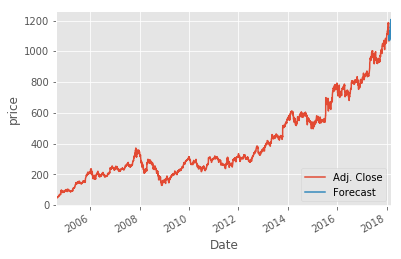

In [19]:
df['Forecast'] = np.nan
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

#now populate dataframe with the new dates and forecast values

for i in forecast_set:
  next_date = datetime.datetime.fromtimestamp(next_unix)
  next_unix += one_day
  df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)] + [i]


# here date is taken as a index which can be checked using df.head()
# df.head()

df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('price')
plt.show()

PLOTTING THE GRAPH

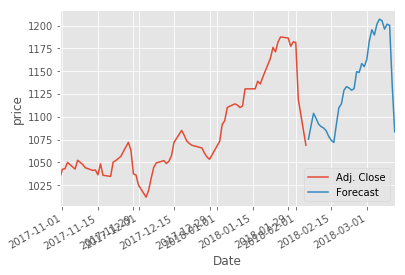

In [23]:
df['Adj. Close'].iloc[-100:df['Forecast'].shape[0]].plot()
df['Forecast'].iloc[-100:df['Forecast'].shape[0]].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('price')
plt.show()